<a href="https://colab.research.google.com/github/gcavalcantt/movie-reviews/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project with Natural Language Processing (NLP)

The goal of this project is to build a model that is sensitive to both negative and positive comments in movie reviews, that is, to develop a sentiment analysis.

# Setting up the Environment
Set up the environment by importing SparkSession and loading data from Google Drive.

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=ed762060f59443820031d11c9626d68f4a0b841392bf25f20260bc2ca792ae32
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analysis_nlp") \
    .getOrCreate()

spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Área de Estudos/Alura/Formações/Apache Spark com Python/spark_database/curso-NLP/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

# Descriptive Analysis
Performed descriptive analysis with PySpark to understand the data structure and the records within the dataset.

In [ ]:
print(f'Number of lines:{data.count()}', f'Number of columns:{len(data.columns)}')

Number of lines:49459 Number of columns:4


In [ ]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
data.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [ ]:
# Some comments labeled as negative or positive

print("Negativo") # Negative
data.filter(data.id == 190).select("text_pt").show(truncate = False)

print("Positivo") # Positive
data.filter(data.id == 12427).select("text_pt").show(truncate = False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [ ]:
data.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



# Word Cloud
Created a word cloud to better visualize the main words in the dataset by importing the WordCloud and Matplotlib libraries. Additionally, within Spark ML, I executed word tokenization and created StopWords using the NLTK library.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sample = data.select('text_pt').sample(fraction = 0.1, seed = 101)
all_texts = [text['text_pt'] for text in sample.collect()]

In [ ]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False,
                      prefer_horizontal = 1).generate(str(all_texts))

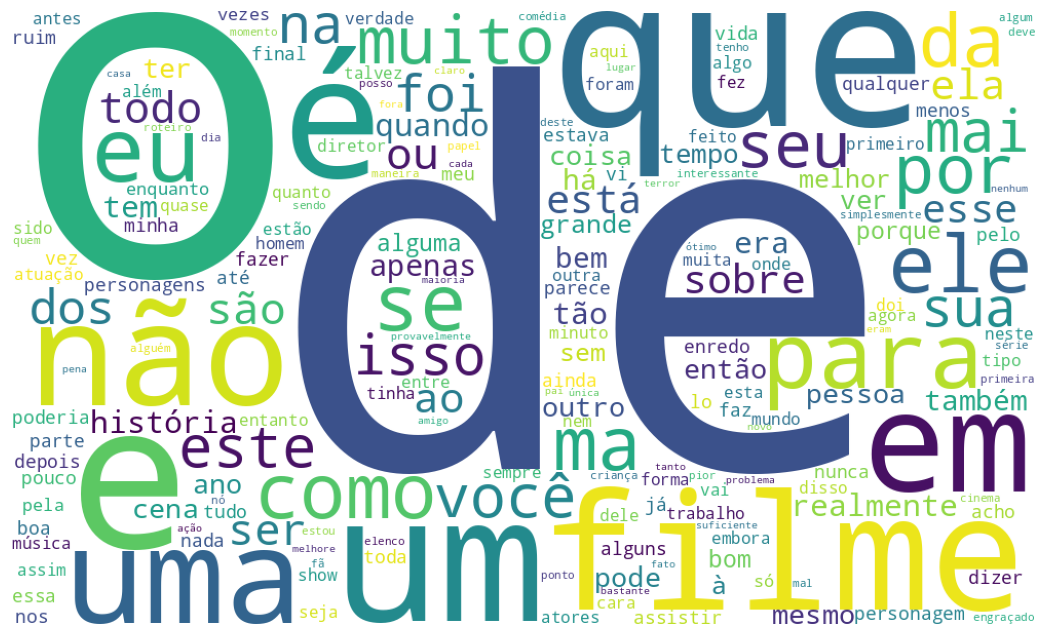

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Data Cleaning

In [ ]:
# Need to remove all that punctuations

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from pyspark.sql import functions as f

data = data.withColumn("text_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [ ]:
data.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
data = data.withColumn("clean_text", f.trim(data.text_regex) )

In [ ]:
data.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



### Tokenization

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "tokens")
tokenized = tokenizer.transform(data)

In [ ]:
tokenized.select("clean_text", "tokens").show()

+--------------------+--------------------+
|          clean_text|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
from pyspark.sql.types import IntegerType

# Understanding how many tokens the comments were divided into
# Spark automatically converts all letters to lowercase during the tokenization process

countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenized.select("clean_text", "tokens")\
          .withColumn("freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|          clean_text|              tokens|freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

### Stop Words

In [ ]:
# Exemple

data2 = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
        (0, 'Spark MLlib não ajuda muito'),
        (1, 'O MLlib do Spark ajuda e é fácil')]

colNames = ['label', 'clean_text']
df = spark.createDataFrame(data2, colNames)

In [ ]:
# Example exploring libraries with NLTK
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Example exploring libraries with Spark
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [ ]:
# Example A - comparing the different stopwords
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "tokens")
tokenized = tokenizer.transform(df)

In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol = "final_text", stopWords= stop_A)
df = remover.transform(tokenized)

In [ ]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|clean_text                           |tokens                                         |final_text                       |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [ ]:
# Example B - comparing the different stopwords

remover = StopWordsRemover(inputCol = "tokens", outputCol = "final_text", stopWords=stop_B)
df = remover.transform(tokenized)

In [ ]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|clean_text                           |tokens                                         |final_text                             |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



Implementing Stop Words

In [ ]:
from pyspark.ml.feature import StopWordsRemover

remove = StopWordsRemover(inputCol = "tokens", outputCol = "final_text")
feature_data = remove.transform(tokenized)

In [ ]:
feature_data.limit(11).show()

+-----+--------------------+--------------------+--------------------+
|label|          clean_text|              tokens|          final_text|
+-----+--------------------+--------------------+--------------------+
|    1|Spark é ótimo e N...|[spark, é, ótimo,...|[spark, é, ótimo,...|
|    0|Spark MLlib não a...|[spark, mllib, nã...|[spark, mllib, nã...|
|    1|O MLlib do Spark ...|[o, mllib, do, sp...|[o, mllib, spark,...|
+-----+--------------------+--------------------+--------------------+



In [ ]:
# Token count before and after stopwords removal

feature_data.select("tokens", "final_text")\
          .withColumn("freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("clean_freq_tokens",  countTokens(f.col("final_text"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|          final_text|freq_tokens|clean_freq_tokens|
+--------------------+--------------------+-----------+-----------------+
|[spark, é, ótimo,...|[spark, é, ótimo,...|          9|                9|
|[spark, mllib, nã...|[spark, mllib, nã...|          5|                5|
|[o, mllib, do, sp...|[o, mllib, spark,...|          8|                7|
+--------------------+--------------------+-----------+-----------------+



# Vectorization
With the tokenized data, I vectorized them and, within the Spark ML context, constructed the "Bag of Words" using Count Vectorizer, HashingTF, and TF-IDF. Both were used to compare which method performed better and generated the best results.

Bag of Words: count the number of words in the vocabulary.

### Count Vectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="final_text", outputCol="CountVec")
model = cv.fit(df)
df = model.transform(df)

In [ ]:
df.select('final_text', 'CountVec').show(truncate = False)

# There are seven words in total. For example, the word "ajuda" is designated as word number "3", as the number 3 only appears in the two vectorized rows below, representing the index of the words.

+---------------------------------------+-------------------------------------+
|final_text                             |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [ ]:
# What are the words?

model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [ ]:
cv = CountVectorizer(inputCol="final_text", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

# For each observation, a vector is generated with the following structure: `[number of features, [word codes in the order of the vocabulary], [frequency of each word]]`
# If we have `(4, [1, 2], [1, 1])`, it means that in the dataset, we have four different words that make up our vocabulary
# In this line, we have the second and third words of the vocabulary `(1, 2)`, and each of them appears only once

In [ ]:
countVectorizer_features.select('final_text','CountVec').limit(5).show(truncate=False)

+-----------------------------------------------+---------------------------------------------------+
|final_text                                     |CountVec                                           |
+-----------------------------------------------+---------------------------------------------------+
|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|(12,[0,1,3,4,8,9,11],[2.0,2.0,1.0,1.0,1.0,1.0,1.0])|
|[spark, mllib, não, ajuda, muito]              |(12,[0,2,5,6,10],[1.0,1.0,1.0,1.0,1.0])            |
|[o, mllib, spark, ajuda, e, é, fácil]          |(12,[0,1,2,3,4,5,7],[1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
+-----------------------------------------------+---------------------------------------------------+



### Hashing TF

In [ ]:
# Hashing TF is an alternative option to CountVectorizer that limits the number of words; in this case, 50 different words will be counted. `numFeatures=1000`
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="final_text", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [ ]:
HTFfeaturizedData.select("final_text", "hashingTF").limit(5).show()

+--------------------+--------------------+
|          final_text|           hashingTF|
+--------------------+--------------------+
|[spark, é, ótimo,...|(50,[0,3,11,18,36...|
|[spark, mllib, nã...|(50,[21,25,27,28,...|
|[o, mllib, spark,...|(50,[0,3,6,18,25,...|
+--------------------+--------------------+



### TF-IDF

In [ ]:
# TF-IDF not only counts the different words but also assigns weights to each one based on their prevalence in the data
from pyspark.ml.feature import IDF

idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [ ]:
TFIDFfeaturizedData.select('final_text', 'features').limit(5).show(truncate = False)

+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|final_text                                     |features                                                                                                                                             |
+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|(50,[0,3,11,18,36,39,42],[0.28768207245178085,0.5753641449035617,0.6931471805599453,0.28768207245178085,0.0,0.6931471805599453,0.6931471805599453])  |
|[spark, mllib, não, ajuda, muito]              |(50,[21,25,27,28,36],[0.6931471805599453,0.28768207245178085,0.6931471805599453,0.28768207245178085,0.0])                                            |


In [ ]:
TFIDFfeaturizedData.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|    2|
|    0|    1|
+-----+-----+



### Encoding

In [ ]:
# Converting strings to numbers
from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
data = stringindexer.fit(data).transform(data)

In [ ]:
# Who is "0" and who is "1"?

data.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



# Pipeline
After these processes, I aggregated all these changes and preparations into a Pipeline, as gathering all the classes used into a single cell improves readability and makes the code easier to follow.

In [ ]:
# In this case, the goal of the pipeline is to centralize all the transformations made to the data so far into a sequence of steps for a single execution
# Gathering all the classes used into a single cell improves readability and makes the code easier to understand

from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [ ]:
transformed_data = pipeline.fit(data).transform(data)

In [ ]:
transformed_data.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|label|              tokens|          final_text|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

In [ ]:
featureDF = transformed_data.select(['features', 'label'])

In [ ]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



# Decision Tree - Classification
Executed a Decision Tree focused on classification using the DecisionTreeClassifier and the previously built Pipeline to perform data fitting and prediction, also measuring the accuracy.

### Fitting and Prediction

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="final_text")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

In [ ]:
train, test = data.randomSplit([0.7, 0.3], seed = 101)

In [ ]:
dt_model = pipeline.fit(train)

In [ ]:
predictions = dt_model.transform(test)

In [ ]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|          text_regex|          clean_text|label|              tokens|          final_text|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [366.0,1112.0]|[0.24763193504736...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [ ]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



### Metrics

In [ ]:
# To obtain metrics, I first need to evaluate the model, and then the metrics will be generated
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("Accuracy = %s" % (accuracy))

Accuracy = 0.6700404858299596


# Classifying Results
Finally, I was able to achieve the expected result with a model capable of distinguishing positive and negative arguments.

In [ ]:
new_dataset = spark.createDataFrame([
    (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actors."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "clean_text"])

In [ ]:
new_class = dt_model.transform(new_dataset)

In [ ]:
new_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|          clean_text|              tokens|          final_text|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|  [18.0,10.0]|[0.64285714285714...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[156.0,774.0]|[0.16774193548387...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+



With 0 representing a negative sentiment and 1 representing a positive sentiment, the model was able to understand and classify the first sentence as negative and the second sentence as positive.